In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import itertools
import time

In [32]:
# Инициализация списков для хранения данных
result_title = []
result_price = []
result_year = []
result_milliage = []


# Счетчик неудачных запросов
fail_counter = 0 

# Диапазон страниц для парсинга
page_counter = range(1, 16)

# Определяем url
url = 'https://auto.ru/rossiya/cars/bmw/3er/21398591/all/?in_stock=IN_STOCK'

# Определяем webdriver selenium
driver = webdriver.Chrome()

# Функция для очистки текста цен
def clean_price(text):
    # Убираем символы и переводим в число
    price_str = ''.join(filter(str.isdigit, text))
    return int(price_str) if price_str else None

# Функция для очистки текста пробега
def clean_mileage(text):
    return int(''.join(filter(str.isdigit, text[:7])))

# Время ожидания для загрузки страницы
# delay = 0.5

try:
    for i in page_counter:
        # Объеденяем url и номер страницы
        full_url = f'{url}&page={i}'
        driver.get(full_url)
        
        # Ожидание, чтобы страница полностью загрузилась
        #time.sleep(delay)
        
        # Получаем webelement'ы
        titles = driver.find_elements(By.XPATH, "//a[@class='Link ListingItemTitle__link']")
        prices = driver.find_elements(By.XPATH, "//div[@class='ListingItem__priceBlock']")
        years = driver.find_elements(By.XPATH, "//div[@class='ListingItem__yearBlock']")
        milliages = driver.find_elements(By.XPATH, "//div[@class='ListingItem__kmAge']")
        
        # Если запрос исполнился корректно, то очищаем даннные
        if titles:
            list_title = [title.text[:-10].strip() for title in titles if title.text.strip()]
            list_price = [clean_price(price.text.split('₽')[0]) for price in prices if price.text.strip()]
            list_year = [int(year.text.strip()) for year in years if year.text.strip()]
            list_milliage = [clean_mileage(mill.text) for mill in milliages if mill.text.strip()]

            # Добавление очищенных данных в результирующие списки
            result_title.extend(list_title)
            result_price.extend(list_price)
            result_year.extend(list_year)
            result_milliage.extend(list_milliage)
            
        # если произошла ошибка, прибавляем счетчик
        else:
            fail_counter += 1

finally:
    # Закрываем браузер после выполнения
    driver.quit()

In [33]:
# Создание DataFrame 
df = pd.DataFrame({
    'model': result_title,
    'price': result_price,
    'year': result_year,
    'milliage': result_milliage
})

In [34]:

df.shape

(555, 4)

In [35]:
df.head()

,model,price,year,milliage
0,BMW 3 серии 330d xDrive,5600000,2020,52000
1,BMW 3 серии 320d xDrive,5079300,2020,56300
2,BMW 3 серии 330i,3380000,2020,78000
3,BMW 3 серии 330i,3300000,2019,38000
4,BMW 3 серии 330i,3300000,2020,71500


In [36]:
fail_counter

0

In [37]:
# Расчет общих описательных статистик
minn =  df['price'].min()
maxx =  df['price'].max()
median = df['price'].median()
avg = round(df['price'].mean(),1)
#mode = df['price'].mode()
std = round(df['price'].std(),1)
print(f" price is - max {maxx}, min {minn}, median {median}, avg {avg}, std {std}")

 price is - max 7200000, min 2850000, median 3899000.0, avg 4054108.6, std 744386.7


In [38]:
# Статистика в группах по годам 
group_year = df.groupby(['year'], as_index=False).agg(cnt_on_group=('year', 'count'), avg_price = ('price', 'mean'), median_price = ('price', 'median'), maxx=('price', 'max'), minn=('price', 'min'), std=('price', 'std'))
group_year['avg_price'] = group_year['avg_price'].round()
group_year['std'] = group_year['std'].round()
group_year

,year,cnt_on_group,avg_price,median_price,maxx,minn,std
0,2018,2,3300000.0,3300000.0,3300000,3300000,0.0
1,2019,215,3771899.0,3729000.0,7000000,2850000,588488.0
2,2020,201,4086244.0,3910000.0,6900000,3000000,732616.0
3,2021,131,4450610.0,4290000.0,7200000,3100000,794078.0
4,2022,6,4684500.0,4829500.0,5349000,3950000,648130.0


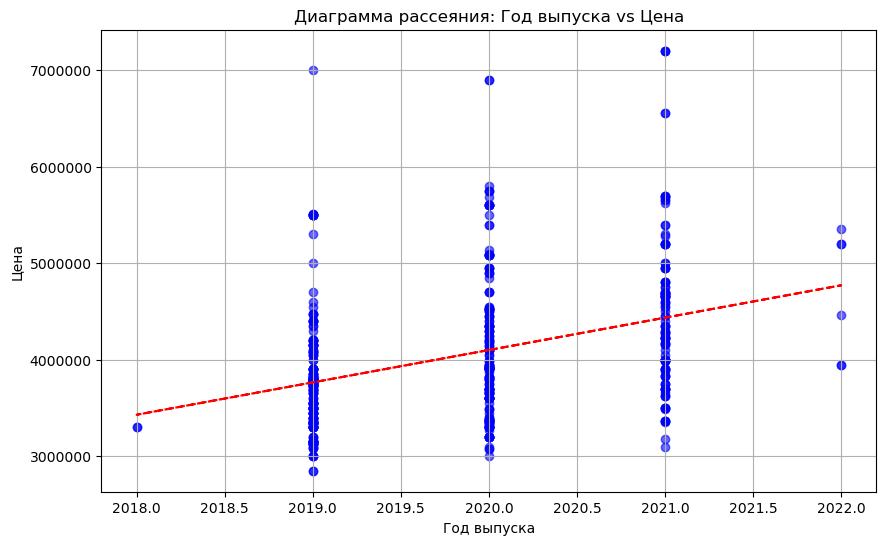

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(df['year'], df['price'], color='blue', alpha=0.6)

# Добавление подписей и заголовков
plt.title('Диаграмма рассеяния: Год выпуска vs Цена')
plt.xlabel('Год выпуска')
plt.ylabel('Цена')

# Настройка масштабирования осей
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ticklabel_format(style='plain', axis='y')  # Делаем так, чтобы ось y отображала большие числа корректно

# Опционально: Добавление трендовой линии
z = np.polyfit(df['year'], df['price'], 1)
p = np.poly1d(z)
plt.plot(df['year'], p(df['year']), "r--")

# Показ графика
plt.grid(True)
plt.show()

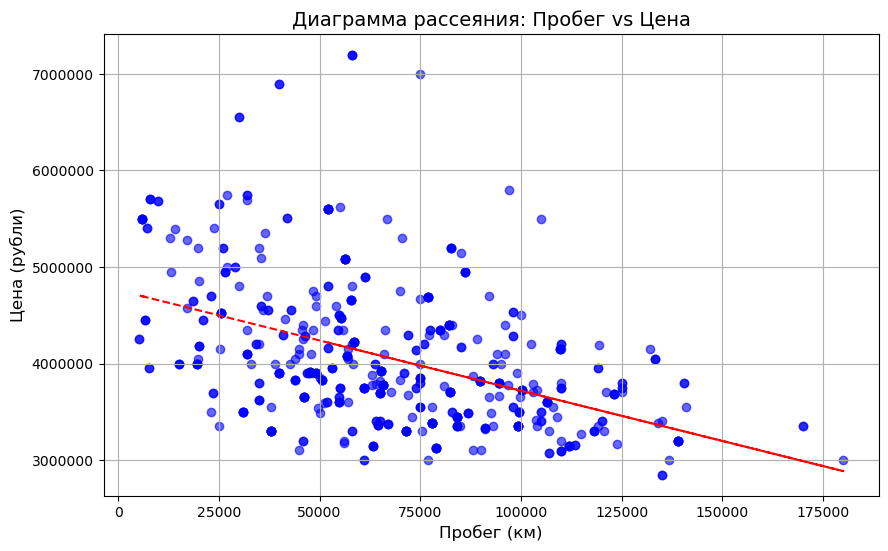

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(df['milliage'], df['price'], color='blue', alpha=0.6)

# Добавление подписей и заголовков
plt.title('Диаграмма рассеяния: Пробег vs Цена', fontsize=14)
plt.xlabel('Пробег (км)', fontsize=12)
plt.ylabel('Цена (рубли)', fontsize=12)

# Настройка масштабирования осей
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ticklabel_format(style='plain', axis='y')  # Делаем так, чтобы ось y отображала большие числа корректно

# Опционально: Добавление трендовой линии
z = np.polyfit(df['milliage'], df['price'], 1)
p = np.poly1d(z)
plt.plot(df['milliage'], p(df['milliage']), "r--")

# Показ графика
plt.grid(True)
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


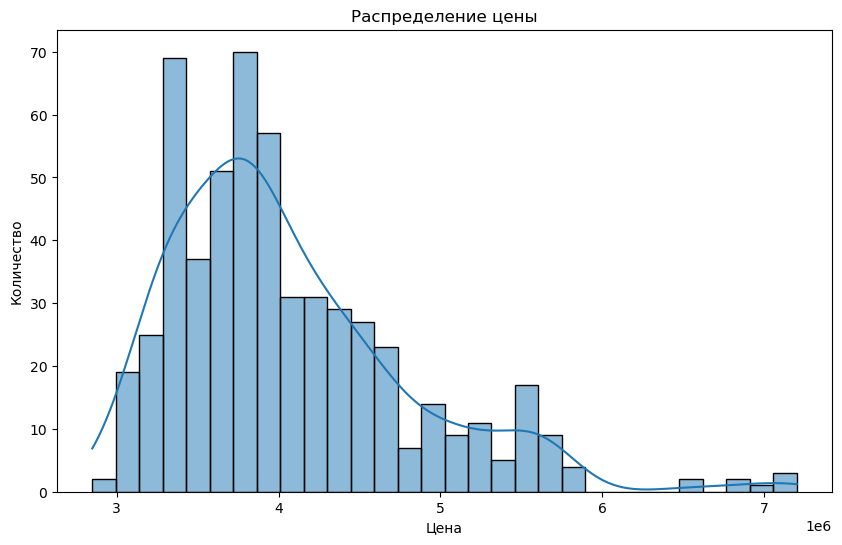

In [41]:
# Гистограмма распределения цены
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Распределение цены')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

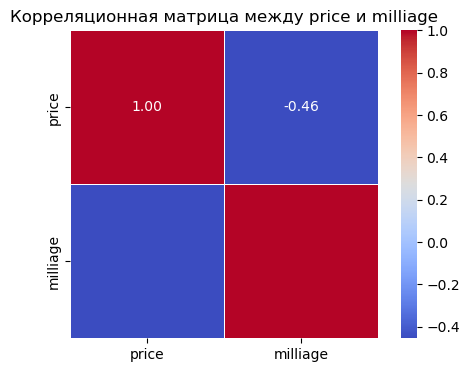

In [42]:
# Выбираем только нужные столбцы
data = df[['price', 'milliage']]

# Вычисляем корреляционную матрицу
correlation_matrix = data.corr()

plt.figure(figsize=(6, 4))  # Определяем размер графика
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f',
            cbar=True, square=True, linewidths=.5)
plt.title('Корреляционная матрица между price и milliage')  # Заголовок графика
plt.show()  # Отображаем график

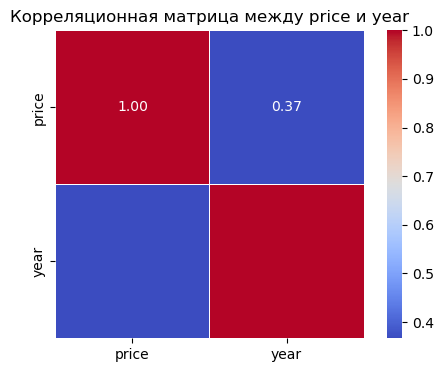

In [43]:
# Выбираем только нужные столбцы
data = df[['price', 'year']]

# Вычисляем корреляционную матрицу
correlation_matrix = data.corr()

plt.figure(figsize=(6, 4))  # Определяем размер графика
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f',
            cbar=True, square=True, linewidths=.5)
plt.title('Корреляционная матрица между price и year')  # Заголовок графика
plt.show()  # Отображаем график